<a href="https://colab.research.google.com/github/OJB-Quantum/Notebooks-for-Ideas/blob/main/LUMO_and_HOMO_Molecular_Orbital_Comparisons.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Authored by Onri Jay Benally (2025)

Open Access (CC-BY-4.0)

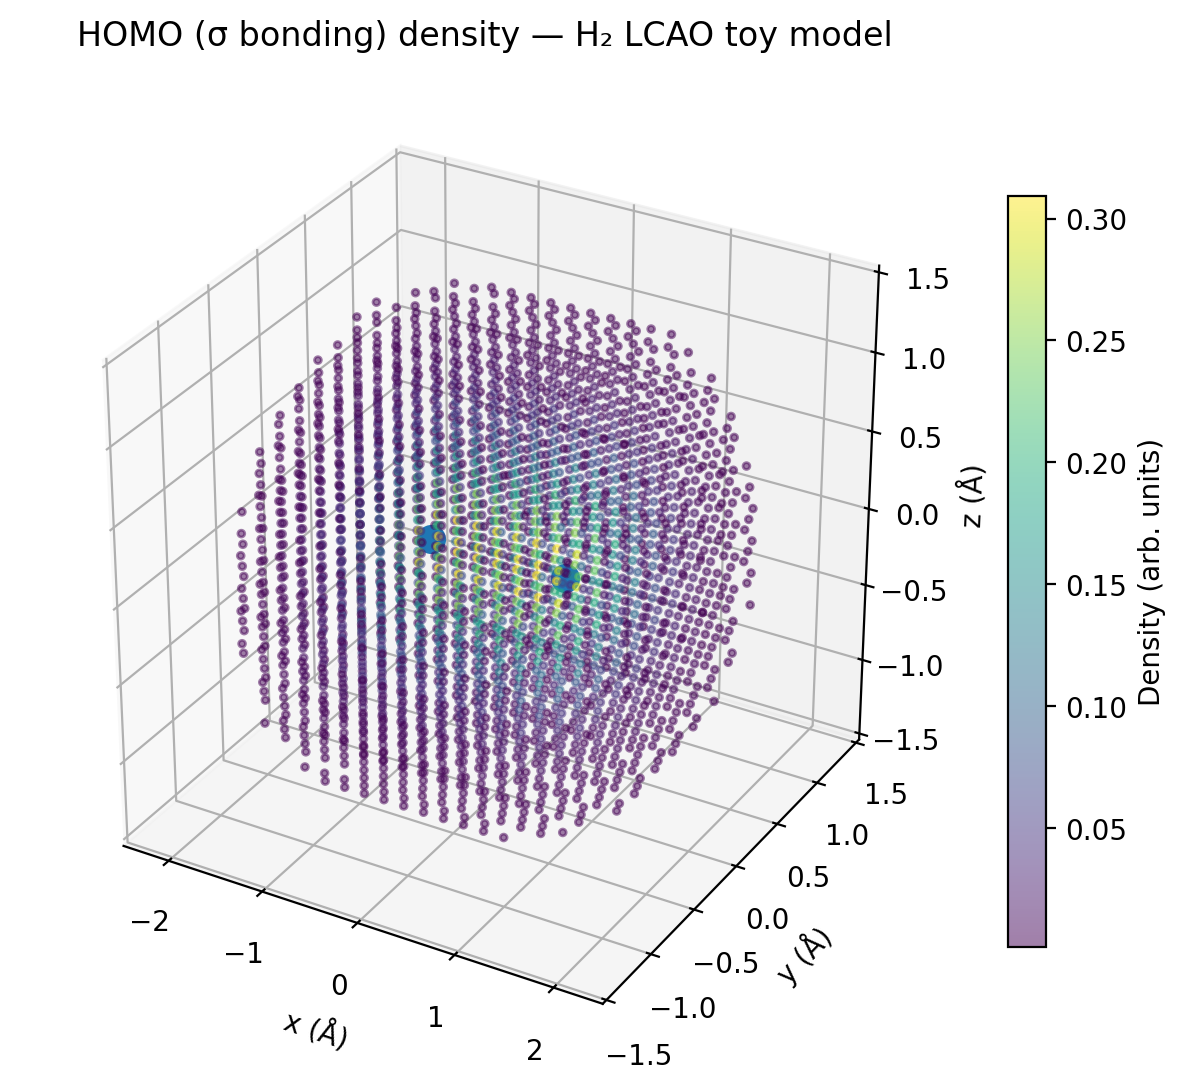

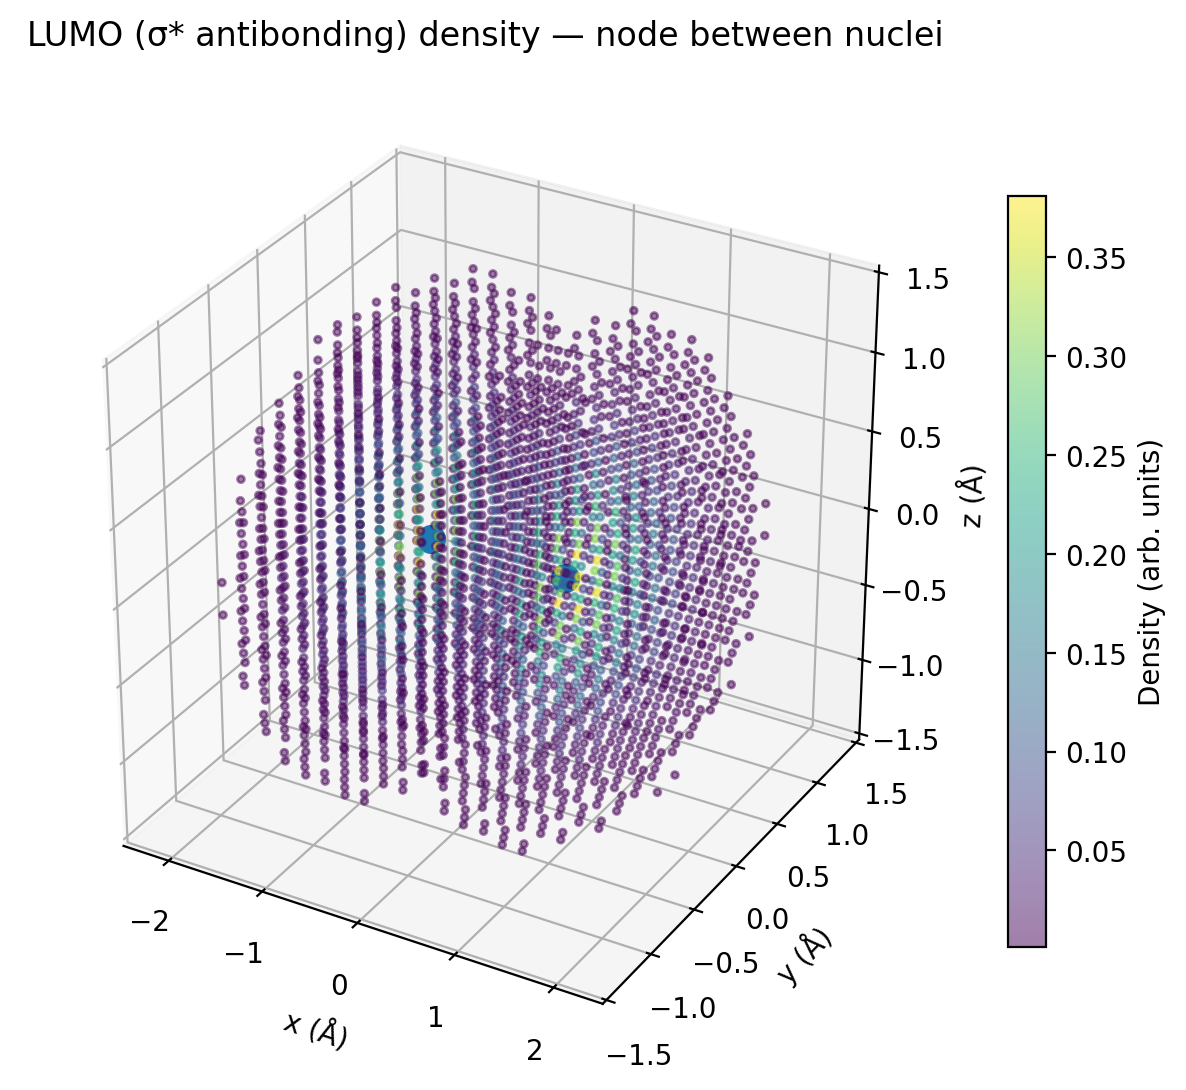

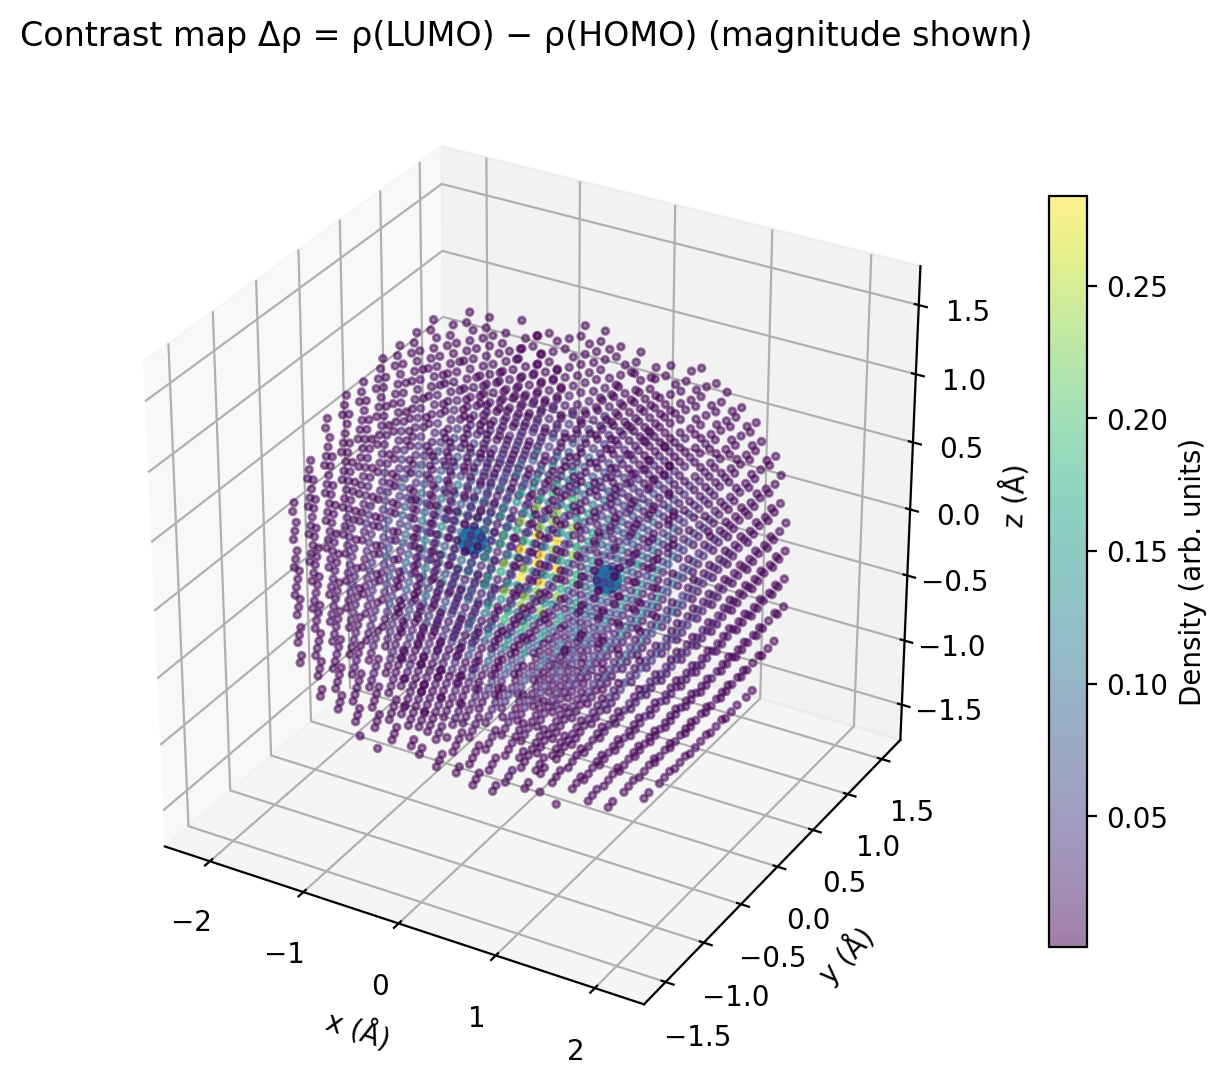

Saved figures:
- /content/data/HOMO_density_3D.png
- /content/data/LUMO_density_3D.png
- /content/data/LUMO_minus_HOMO_contrast_3D.png


In [ ]:
# 3D "heat map" of HOMO vs LUMO using a simple LCAO model for H2
# - Pure NumPy + Matplotlib (no internet access needed).
# - We visualize electron densities ρ = |ψ|^2 for the bonding (HOMO) and antibonding (LUMO) orbitals.
# - The model uses two 1s-like Gaussian atomic orbitals placed at ±R/2 along x.
#
# Notes:
# • This is a pedagogical toy model capturing the qualitative shape (bonding density between nuclei; antibonding node).
# • We normalize numerically on the chosen grid to compare densities on equal footing.
# • We show three separate 3D scatter "heat maps": HOMO (σ), LUMO (σ*), and a contrast map Δρ = ρ_LUMO − ρ_HOMO.
# • No custom colormaps are set; Matplotlib defaults are used, as requested.
#
# Adjustable parameters are grouped near the top.

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401  (needed for 3D projection side-effects)
from pathlib import Path

plt.rcParams['figure.dpi'] = 200

# ----------------------
# Adjustable parameters
# ----------------------
R = 1.40            # Approximate H–H bond length (Å), purely illustrative
alpha = 1.2         # Gaussian width parameter (larger -> tighter AO lobes)
grid_N = 30         # Grid size per dimension (30^3 points total)
extent = 3.0        # Half-range of the simulation cube in Å (box is [-extent, +extent]^3)
keep_top_quantile = 0.90  # Keep only the upper quantile of density for clearer 3D scatter
marker_size = 6          # Scatter point size
marker_alpha = 0.50      # Scatter transparency
title_pad = 22           # Extra padding above each title
outdir = Path("/content/data")
outdir.mkdir(parents=True, exist_ok=True)

# ----------------------
# Helpers
# ----------------------
def gaussian_1s(x, y, z, x0, y0, z0, a):
    """Unnormalized 1s-like Gaussian centered at (x0,y0,z0): exp(-a * r^2)."""
    return np.exp(-a * ((x - x0)**2 + (y - y0)**2 + (z - z0)**2))

def normalize_on_grid(psi, dV):
    """Return psi normalized so that ∑|psi|^2 dV = 1 on the grid."""
    norm = np.sqrt(np.sum(np.abs(psi)**2) * dV)
    return psi / (norm if norm != 0 else 1.0)

def make_grid(n, L):
    """Create a cubic grid of n^3 points covering [-L, +L] in each dimension."""
    axis = np.linspace(-L, L, n)
    X, Y, Z = np.meshgrid(axis, axis, axis, indexing="xy")
    d = (2 * L) / (n - 1)  # grid spacing (assumes uniform spacing)
    dV = d**3
    return X, Y, Z, dV

def select_top_quantile(X, Y, Z, rho, q):
    """Flatten arrays and keep only points where rho >= quantile q."""
    flat = rho.ravel()
    cutoff = np.quantile(flat, q)
    mask = rho >= cutoff
    return X[mask].ravel(), Y[mask].ravel(), Z[mask].ravel(), rho[mask].ravel()

def scatter3d_density(Xs, Ys, Zs, vals, title, atoms=None, savefile=None):
    """3D scatter with values driving default colormap; optional atoms list of (x,y,z)."""
    fig = plt.figure(figsize=(7.5, 6.5))
    ax = fig.add_subplot(111, projection="3d")
    sc = ax.scatter(Xs, Ys, Zs, c=vals, s=marker_size, alpha=marker_alpha)
    # Nuclei markers (larger, neutral style)
    if atoms:
        ax.scatter(*zip(*atoms), s=90, depthshade=False)
    ax.set_title(title, pad=title_pad)
    ax.set_xlabel("x (Å)")
    ax.set_ylabel("y (Å)")
    ax.set_zlabel("z (Å)")
    ax.set_box_aspect((1, 1, 1))
    plt.colorbar(sc, ax=ax, shrink=0.75, pad=0.05, label="Density (arb. units)")
    if savefile:
        fig.savefig(savefile, dpi=300, bbox_inches="tight")
    plt.show()

# ----------------------
# Build grid & orbitals
# ----------------------
X, Y, Z, dV = make_grid(grid_N, extent)

# Two 1s-like atomic orbitals for hydrogen nuclei at ±R/2 along x
A = (-R/2, 0.0, 0.0)
B = (+R/2, 0.0, 0.0)

phi_A = gaussian_1s(X, Y, Z, *A, a=alpha)
phi_B = gaussian_1s(X, Y, Z, *B, a=alpha)

# Bonding (σ) and antibonding (σ*) molecular orbitals via LCAO
psi_bond_raw = phi_A + phi_B          # constructive interference between nuclei
psi_antibond_raw = phi_A - phi_B      # destructive interference between nuclei (node between atoms)

# Normalize on the grid
psi_bond = normalize_on_grid(psi_bond_raw, dV)
psi_antibond = normalize_on_grid(psi_antibond_raw, dV)

# Electron densities
rho_HOMO = np.abs(psi_bond)**2        # H2 ground state: σ (bonding) is HOMO (filled)
rho_LUMO = np.abs(psi_antibond)**2    # σ* (antibonding) is the LUMO (empty in H2)

# Contrast map
delta_rho = rho_LUMO - rho_HOMO

# Select top quantile for clearer 3D point cloud
Xs_H, Ys_H, Zs_H, v_H = select_top_quantile(X, Y, Z, rho_HOMO, keep_top_quantile)
Xs_L, Ys_L, Zs_L, v_L = select_top_quantile(X, Y, Z, rho_LUMO, keep_top_quantile)
Xs_D, Ys_D, Zs_D, v_D = select_top_quantile(X, Y, Z, np.abs(delta_rho), keep_top_quantile)  # magnitude for display

# Atom positions for reference
atoms = [A, B]

# ----------------------
# Render three separate figures (no subplots)
# ----------------------
homo_path = outdir / "HOMO_density_3D.png"
lumo_path = outdir / "LUMO_density_3D.png"
delta_path = outdir / "LUMO_minus_HOMO_contrast_3D.png"

scatter3d_density(
    Xs_H, Ys_H, Zs_H, v_H,
    title="HOMO (σ bonding) density — H\u2082 LCAO toy model",
    atoms=atoms,
    savefile=str(homo_path)
)

scatter3d_density(
    Xs_L, Ys_L, Zs_L, v_L,
    title="LUMO (σ* antibonding) density — node between nuclei",
    atoms=atoms,
    savefile=str(lumo_path)
)

scatter3d_density(
    Xs_D, Ys_D, Zs_D, v_D,
    title="Contrast map Δρ = ρ(LUMO) − ρ(HOMO) (magnitude shown)",
    atoms=atoms,
    savefile=str(delta_path)
)

print(f"Saved figures:\n- {homo_path}\n- {lumo_path}\n- {delta_path}")


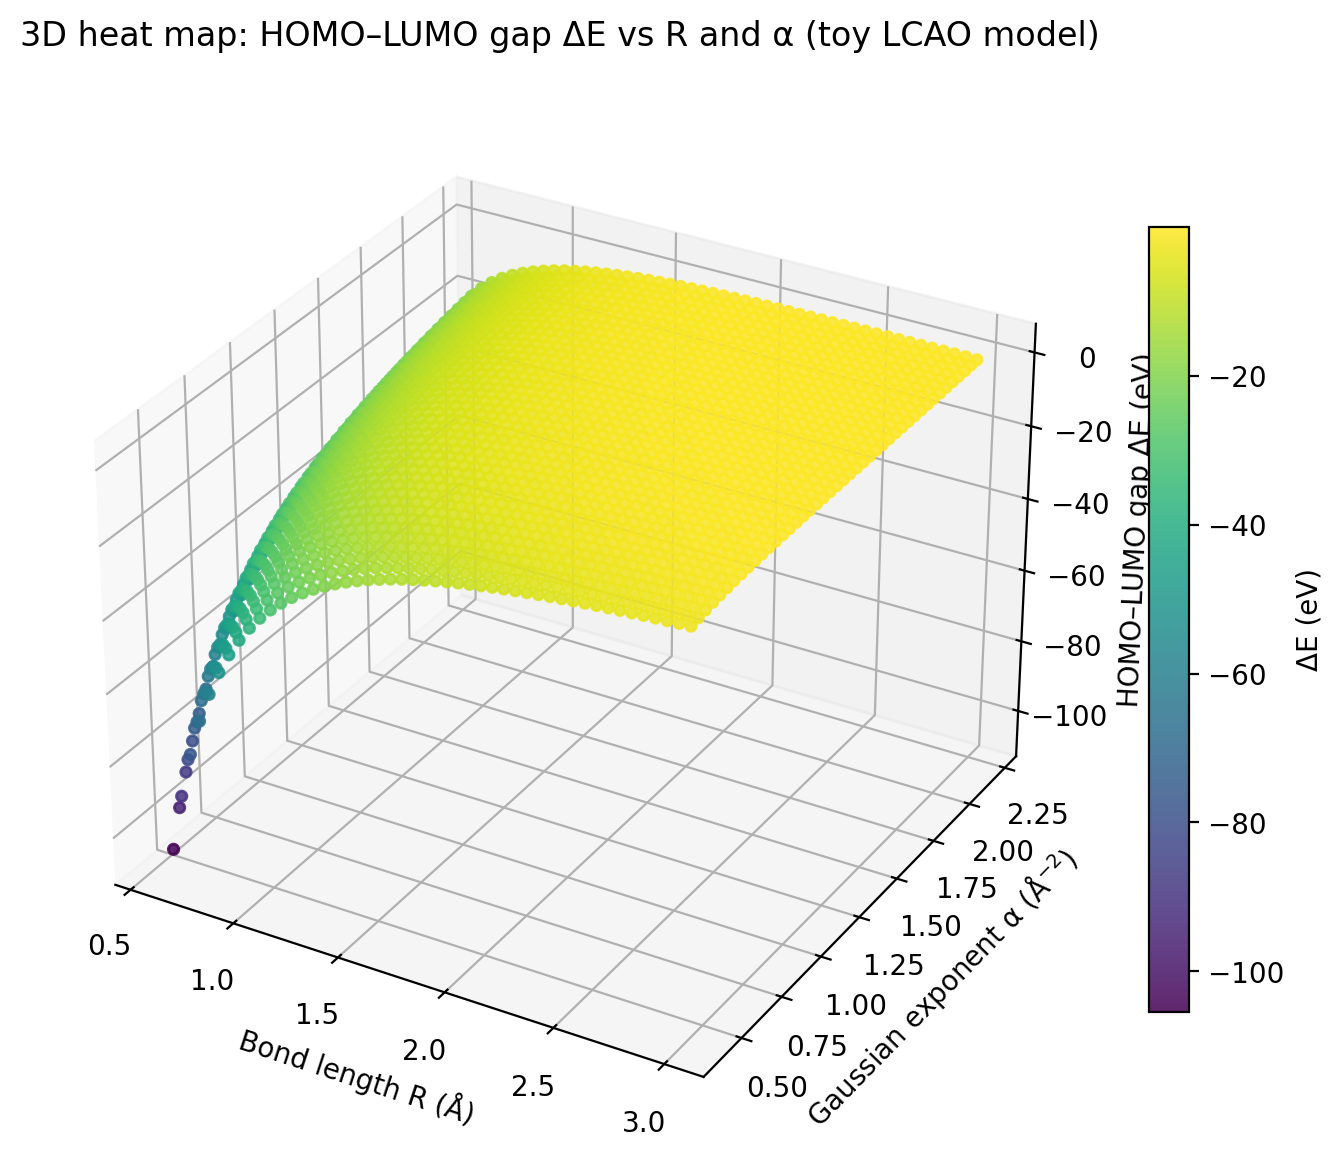

Saved 3D gap figure: /content/data/HOMO_LUMO_gap_3D.png
Saved CSV of grid values: /content/data/HOMO_LUMO_gap_grid.csv
Example gap at R=1.40 Å, α=1.20 Å⁻² -> ΔE ≈ -5.183 eV


In [ ]:
# 3D heat map of the HOMO–LUMO energy gap using a minimalist LCAO diatomic model
# - We model a homonuclear diatomic with two identical 1s-like Gaussian AOs.
# - Overlap S(R, α) for equal-exponent normalized 3D Gaussians: S = exp(-α * R^2 / 2).
# - Off-diagonal Hamiltonian element is parameterized as β(R, α) = β0 * S (tight-binding-like).
# - On-site energy ε is a constant (hydrogenic reference). Units: electron volts (eV).
# - Molecular orbital energies (generalized eigenproblem, homonuclear, 2×2) are approximated by:
#     E_bond   = (ε + β) / (1 + S)
#     E_antib  = (ε - β) / (1 - S)
#   Then the HOMO–LUMO gap is ΔE = E_antib − E_bond  (positive for β < 0).
#
# We visualize ΔE as a function of bond length R (Å) and Gaussian exponent α (Å⁻²)
# with a 3D scatter "heat map" (color encodes ΔE). No seaborn; 1 chart per figure; no explicit colors set.

import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# ----------------------
# Parameters
# ----------------------
eps_eV = -13.6         # on-site (Coulomb) energy ε in eV (hydrogenic reference)
beta0_eV = -6.0        # coupling prefactor β0 in eV (negative => bonding stabilization)
R_min, R_max, R_N = 0.6, 3.0, 48        # bond length range (Å) and sample count
a_min, a_max, a_N = 0.4, 2.2, 44        # Gaussian exponent α range (Å⁻²) and sample count

# ----------------------
# Grid & model
# ----------------------
R_vals = np.linspace(R_min, R_max, R_N)
a_vals = np.linspace(a_min, a_max, a_N)
R_grid, a_grid = np.meshgrid(R_vals, a_vals, indexing="xy")

S = np.exp(-(a_grid * (R_grid**2)) / 2.0)      # overlap
beta = beta0_eV * S                             # coupling
# Avoid singularities as S -> 1
eps = eps_eV
E_bond  = (eps + beta) / (1.0 + S)
E_antib = (eps - beta) / (1.0 - S)
DeltaE  = E_antib - E_bond                      # HOMO–LUMO gap (eV), should be >= 0

# Flatten for 3D scatter
x = R_grid.ravel()
y = a_grid.ravel()
z = DeltaE.ravel()

# ----------------------
# Plot
# ----------------------
fig = plt.figure(figsize=(8.5, 6.8))
ax = fig.add_subplot(111, projection="3d")
pts = ax.scatter(x, y, z, c=z, s=14, alpha=0.85)  # default colormap is used implicitly
ax.set_xlabel("Bond length R (Å)")
ax.set_ylabel("Gaussian exponent α (Å$^{-2}$)")
ax.set_zlabel("HOMO–LUMO gap ΔE (eV)")
ax.set_title("3D heat map: HOMO–LUMO gap ΔE vs R and α (toy LCAO model)", pad=18)
fig.colorbar(pts, ax=ax, shrink=0.75, pad=0.05, label="ΔE (eV)")

# Save
outdir = Path("/content/data")
outdir.mkdir(parents=True, exist_ok=True)
out_path = outdir / "HOMO_LUMO_gap_3D.png"
fig.savefig(out_path, dpi=300, bbox_inches="tight")
plt.show()

# Also export the grid data for reference/use in other tools
import pandas as pd
df = pd.DataFrame({"R_Angstrom": x, "alpha_Ainv2": y, "DeltaE_eV": z})
csv_path = outdir / "HOMO_LUMO_gap_grid.csv"
df.to_csv(csv_path, index=False)

# Example: gap at the settings used in the previous density plots (R≈1.40 Å, α≈1.2 Å⁻²)
R0 = 1.40
a0 = 1.20
S0 = np.exp(-(a0 * (R0**2)) / 2.0)
beta0 = beta0_eV * S0
E_b = (eps + beta0) / (1.0 + S0)
E_a = (eps - beta0) / (1.0 - S0)
DeltaE_example = float(E_a - E_b)

print(f"Saved 3D gap figure: {out_path}")
print(f"Saved CSV of grid values: {csv_path}")
print(f"Example gap at R={R0:.2f} Å, α={a0:.2f} Å⁻² -> ΔE ≈ {DeltaE_example:.3f} eV")

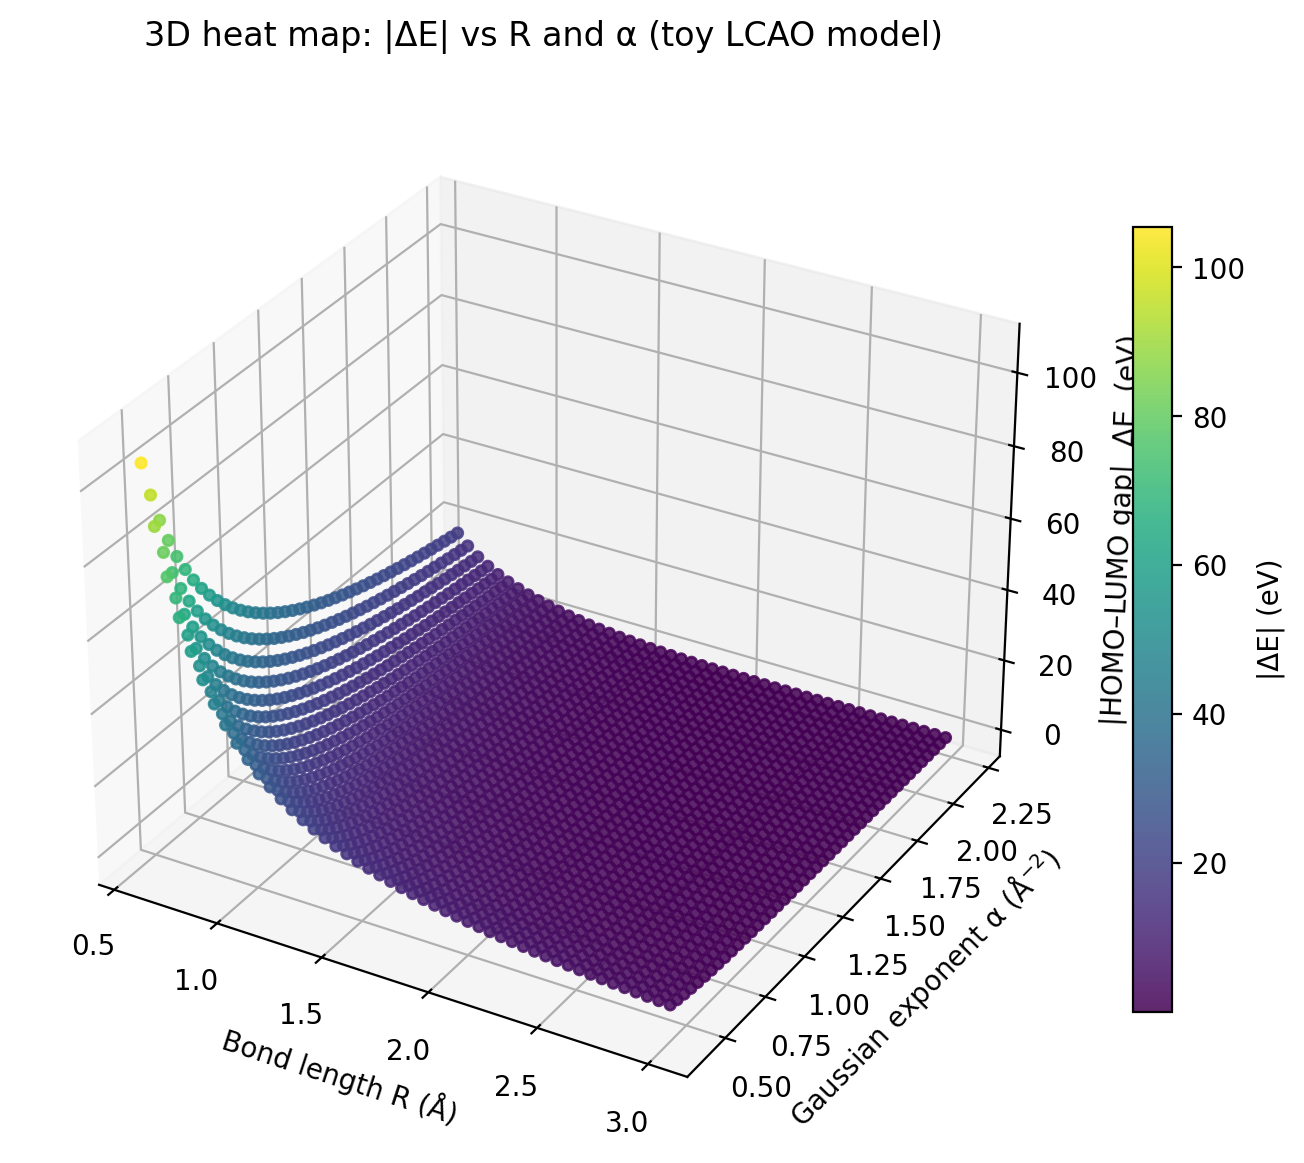

Saved positive-gap figure: /content/data/HOMO_LUMO_gap_3D_positive.png


In [ ]:
# Patch: ensure the HOMO–LUMO gap is plotted as a positive magnitude
# Recompute using the same grids and parameters as above, but enforce ΔE = |E_antib − E_bond|

import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Parameters (same as previous cell)
eps_eV = -13.6
beta0_eV = -6.0
R_min, R_max, R_N = 0.6, 3.0, 48
a_min, a_max, a_N = 0.4, 2.2, 44

R_vals = np.linspace(R_min, R_max, R_N)
a_vals = np.linspace(a_min, a_max, a_N)
R_grid, a_grid = np.meshgrid(R_vals, a_vals, indexing="xy")

S = np.exp(-(a_grid * (R_grid**2)) / 2.0)
beta = beta0_eV * S
eps = eps_eV
E_bond  = (eps + beta) / (1.0 + S)
E_antib = (eps - beta) / (1.0 - S)
DeltaE_mag = np.abs(E_antib - E_bond)

x = R_grid.ravel()
y = a_grid.ravel()
z = DeltaE_mag.ravel()

fig = plt.figure(figsize=(8.5, 6.8))
ax = fig.add_subplot(111, projection="3d")
pts = ax.scatter(x, y, z, c=z, s=14, alpha=0.85)
ax.set_xlabel("Bond length R (Å)")
ax.set_ylabel("Gaussian exponent α (Å$^{-2}$)")
ax.set_zlabel("|HOMO–LUMO gap|  ΔE  (eV)")
ax.set_title("3D heat map: |ΔE| vs R and α (toy LCAO model)", pad=18)
fig.colorbar(pts, ax=ax, shrink=0.75, pad=0.05, label="|ΔE| (eV)")

outdir = Path("/content/data")
outdir.mkdir(parents=True, exist_ok=True)
out_path = outdir / "HOMO_LUMO_gap_3D_positive.png"
fig.savefig(out_path, dpi=300, bbox_inches="tight")
plt.show()

print(f"Saved positive-gap figure: {out_path}")


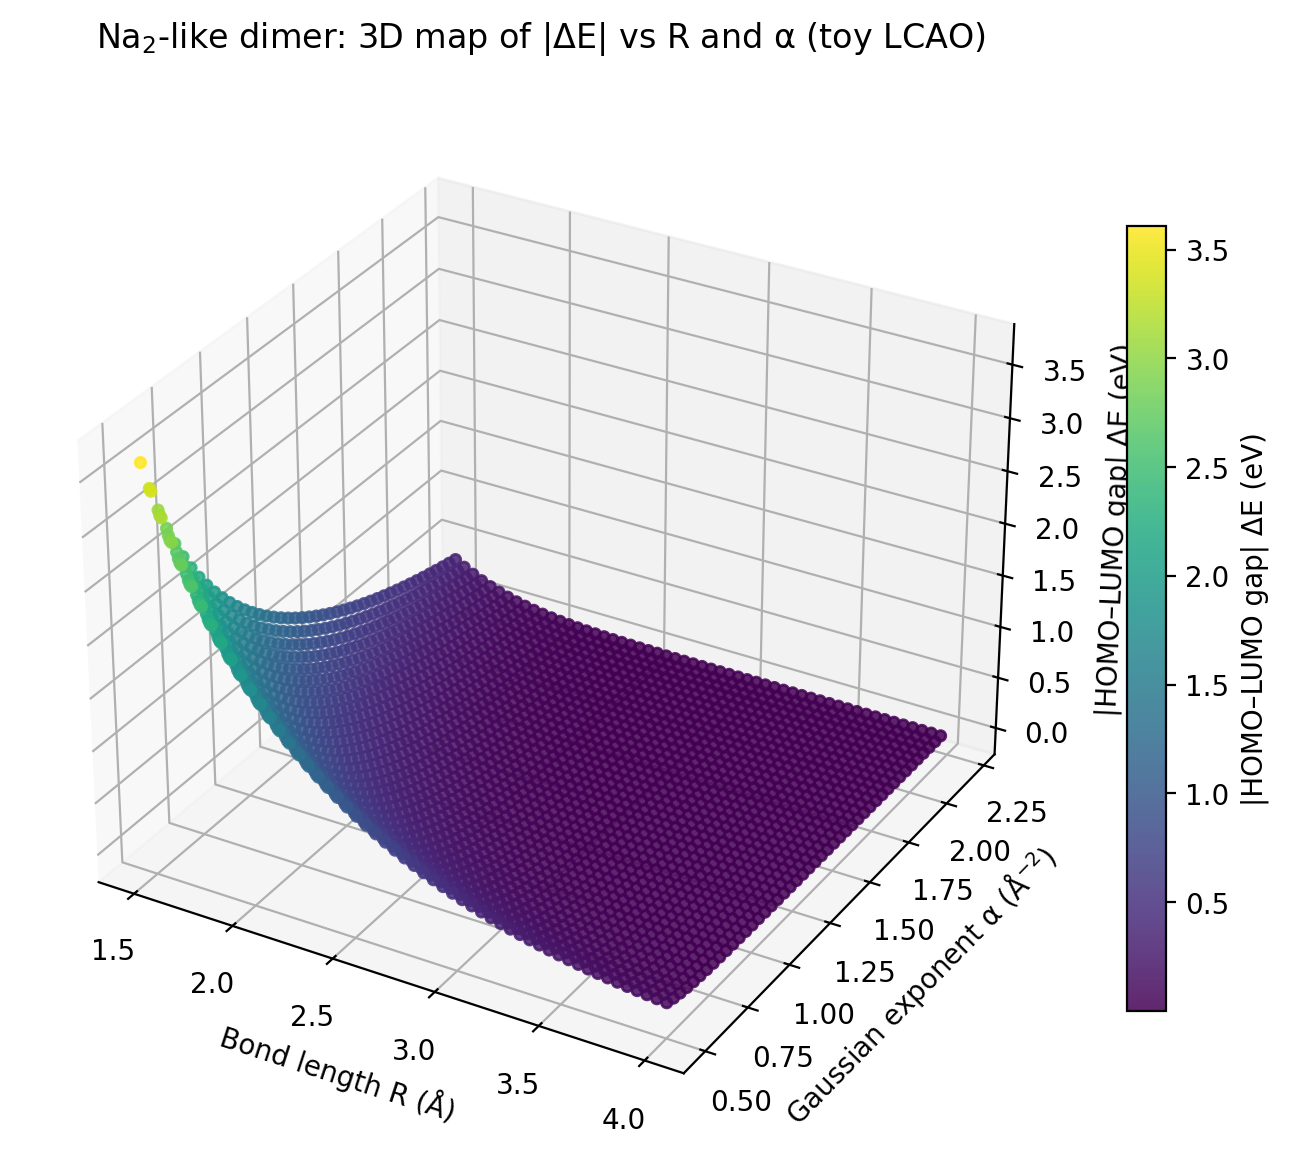

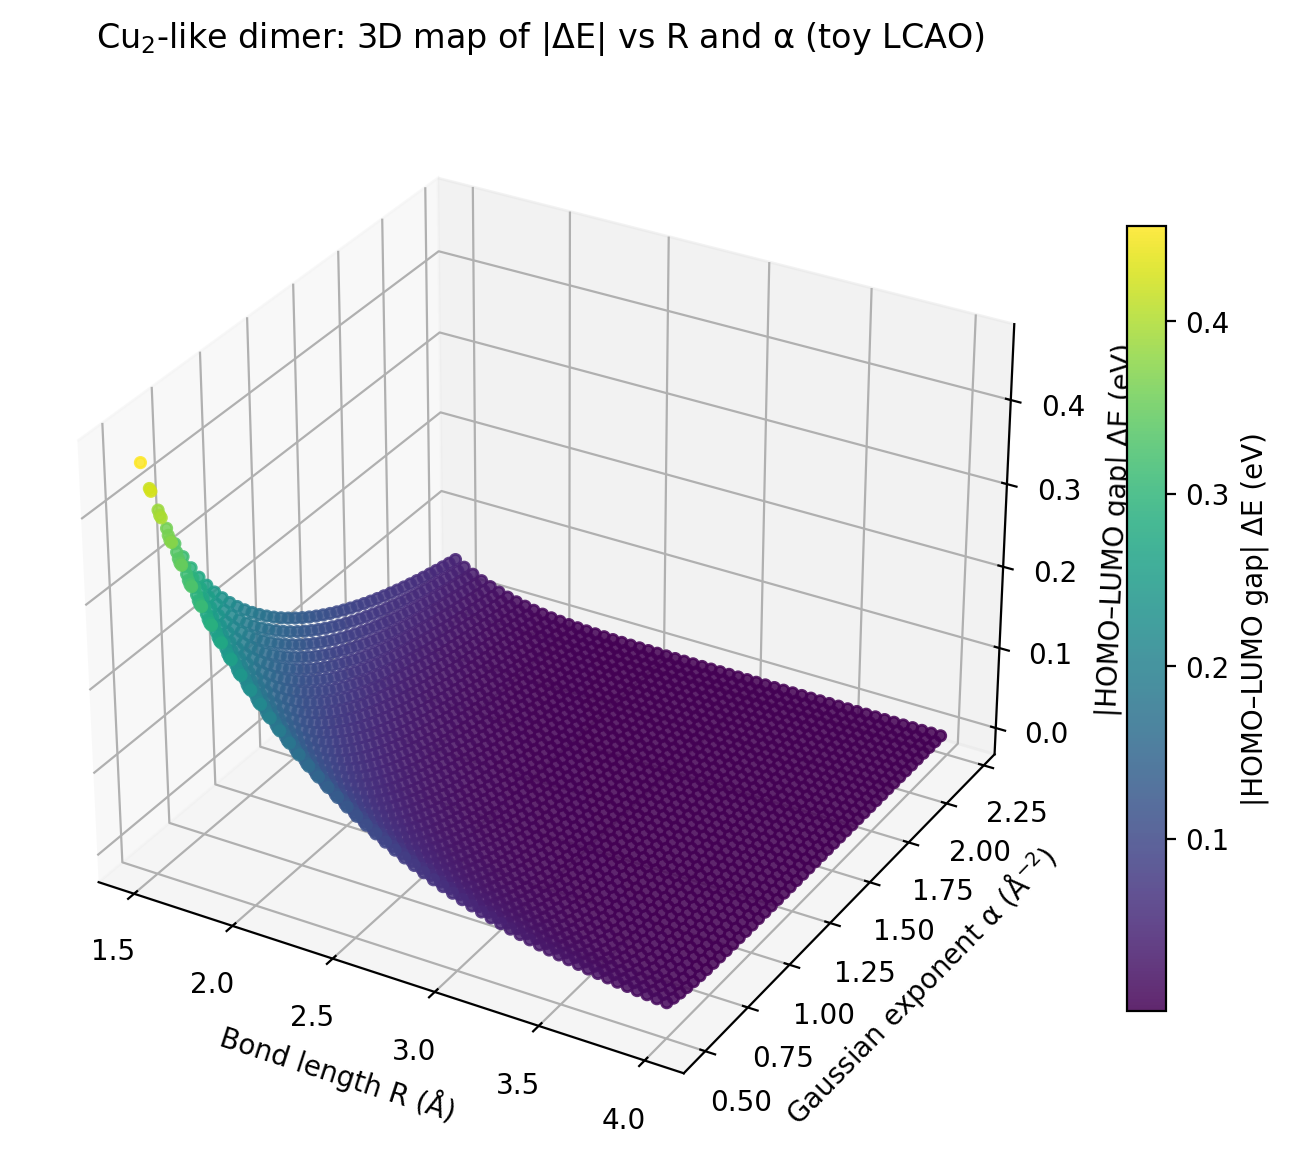

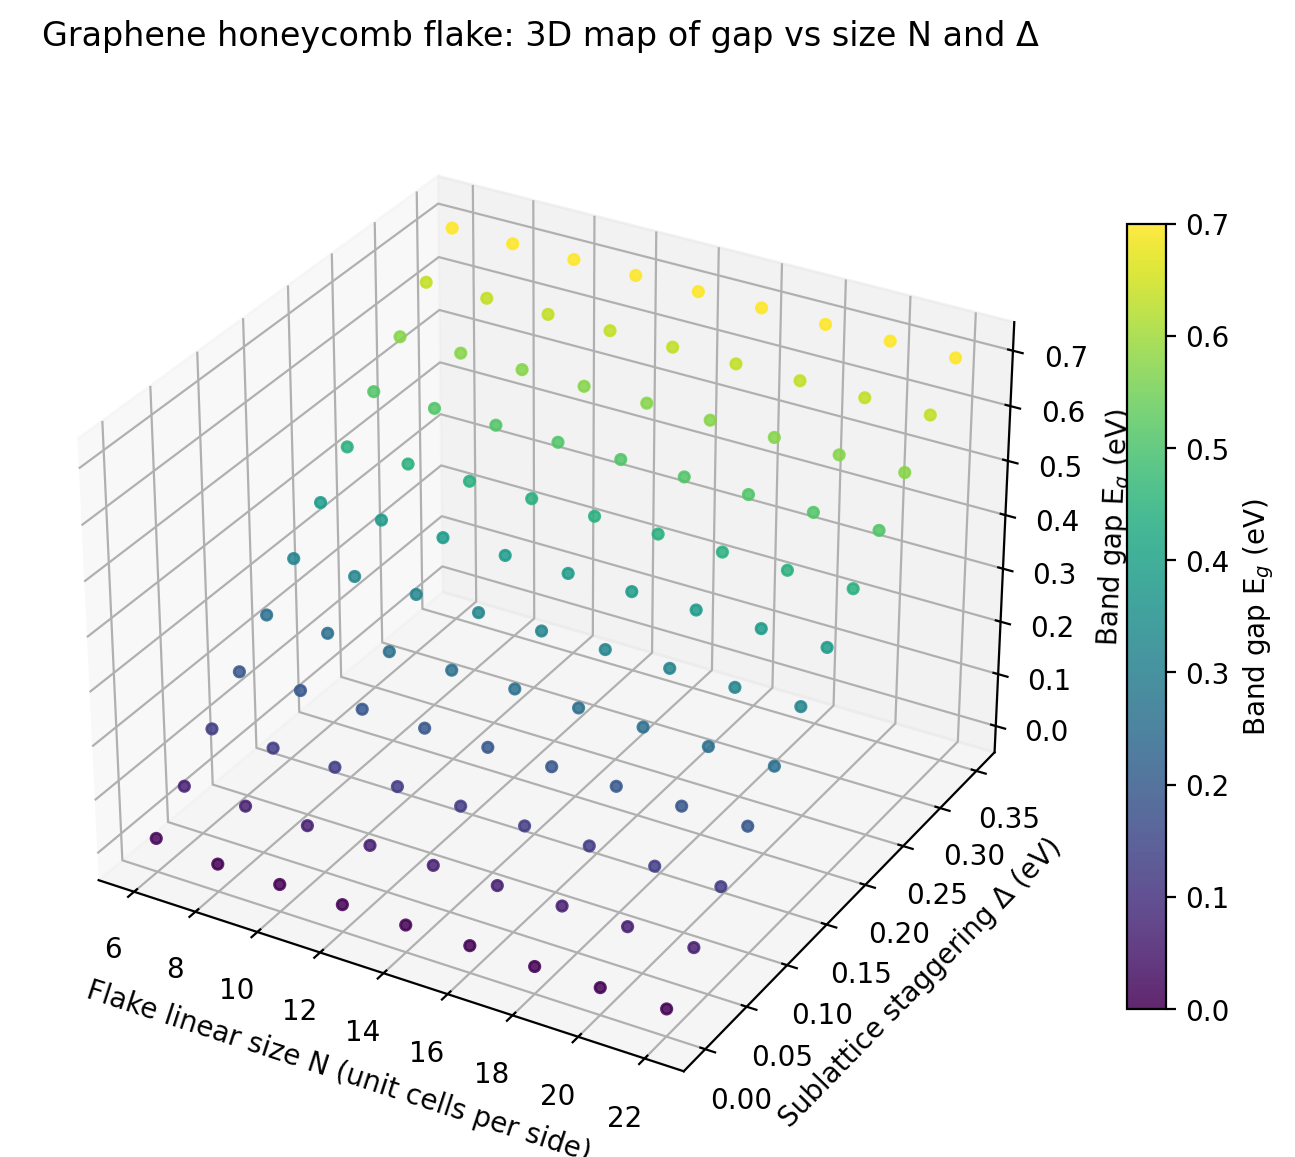

Saved figures:
- /content/data/Na2_like_gap_3D.png
- /content/data/Cu2_like_gap_3D.png
- /content/data/Graphene_flake_gap_3D.png
Saved CSVs:
- /content/data/Na2_like_gap_grid.csv
- /content/data/Cu2_like_gap_grid.csv
- /content/data/Graphene_flake_gap_grid.csv


In [ ]:
# HOMO–LUMO (or band) gap 3D “heat maps” for:
#   (A) Metal dimers: Na2-like and Cu2-like (toy LCAO model)
#   (B) Graphene: finite honeycomb flake (tight-binding π-only) with adjustable sublattice staggering Δ
#
# Design:
# • Metal dimers: reuse the 2×2 LCAO template (HOMO=σ, LUMO=σ*) with ΔE determined by overlap S(R, α) and coupling β(R).
#   We scan bond length R and AO compactness α; show |ΔE| as z & color.
#   Two parameter sets emulate “Na-like” (weaker coupling) vs “Cu-like” (stronger coupling).
# • Graphene flake: build an N×N rectangular honeycomb patch (open boundaries), nearest-neighbor hopping t,
#   and on-site staggering ±Δ on A/B. Gap Eg is min positive eigenvalue – max negative eigenvalue.
#   Scan N and Δ; show Eg as z & color. (For Δ=0, Eg→0 with increasing N; for Δ>0, Eg≈2Δ in bulk.)
#
# Notes:
# • Pure NumPy/Matplotlib; one chart per figure; default colormap.
# • Self-contained; no internet access required.
# • Parameters chosen to be illustrative, fast, and numerically stable.
#
# You can tweak the “User-adjustable parameters” section to explore other regimes.

import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# -----------------------------
# User-adjustable parameters
# -----------------------------
# Metal dimers
R_span = (1.5, 4.0, 55)       # bond length range [Å] and samples
alpha_span = (0.5, 2.2, 45)   # Gaussian exponent α [Å^-2] and samples

# Na2-like
eps_Na = -5.14               # on-site (eV), qualitative reference (not fitted)
beta0_Na = -3.0              # coupling prefactor (eV)
# Cu2-like
eps_Cu = -7.73               # on-site (eV), qualitative reference (not fitted)
beta0_Cu = -8.0              # stronger coupling prefactor (eV)

# Graphene flake
t_graphene = -2.7            # nearest-neighbor hopping (eV)
N_min, N_max, N_step = 6, 22, 2   # flake linear size (unit cells), even numbers
Delta_min, Delta_max, Delta_N = 0.0, 0.35, 12   # sublattice staggering Δ (eV)

# Output
outdir = Path("/content/data"); outdir.mkdir(parents=True, exist_ok=True)

# -----------------------------
# Utilities
# -----------------------------
def metal_gap_grid(eps_eV, beta0_eV, R_span, alpha_span):
    """Compute |ΔE| for a homonuclear diatomic over (R, α) grid using a 2×2 LCAO toy model.
       S = exp(-α R^2 / 2), β = beta0 * S, E_bond = (ε + β)/(1+S), E_antib = (ε - β)/(1-S)."""
    R_vals = np.linspace(*R_span)
    a_vals = np.linspace(*alpha_span)
    Rg, ag = np.meshgrid(R_vals, a_vals, indexing="xy")
    S = np.exp(-(ag * (Rg**2)) / 2.0)
    beta = beta0_eV * S
    E_b = (eps_eV + beta) / (1.0 + S)
    E_a = (eps_eV - beta) / (1.0 - S)
    dE = np.abs(E_a - E_b)
    return Rg.ravel(), ag.ravel(), dE.ravel()

def graphene_flake_build(Nx, Ny):
    """Return TB Hamiltonian for an open-boundary rectangular honeycomb patch:
       - Brick-wall representation (two-atom basis per cell: A,B)
       - Nearest-neighbor hopping t between A↔B
       Indexing: site id = (i,j,s) with s=0(A) or 1(B) -> map to linear index.
    """
    n_sites = 2 * Nx * Ny
    H = np.zeros((n_sites, n_sites), dtype=float)

    def idx(i, j, s):
        return (i * Ny + j) * 2 + s  # linear index

    # neighbor rules for brick-wall honeycomb
    for i in range(Nx):
        for j in range(Ny):
            # A site
            ia = idx(i, j, 0)
            # B neighbors: (i,j), (i-1,j), (i,j-1) when in range
            nbrs = []
            if 0 <= i < Nx and 0 <= j < Ny:
                nbrs.append((i, j))
            if i-1 >= 0:
                nbrs.append((i-1, j))
            if j-1 >= 0:
                nbrs.append((i, j-1))
            for (u, v) in nbrs:
                ib = idx(u, v, 1)
                H[ia, ib] = H[ib, ia] = t_graphene
    return H

def graphene_gap_for(N, Delta):
    """Graphene flake (N×N cells), sublattice staggering ±Δ, return Eg >= 0 (eV)."""
    Nx = Ny = N
    H = graphene_flake_build(Nx, Ny)
    # add sublattice staggering
    for i in range(Nx):
        for j in range(Ny):
            ia = (i * Ny + j) * 2 + 0  # A
            ib = (i * Ny + j) * 2 + 1  # B
            H[ia, ia] += +Delta
            H[ib, ib] += -Delta
    E = np.linalg.eigvalsh(H)
    # HOMO/LUMO around zero (half-filling)
    # For even number of states, spectrum is symmetric about 0 when Δ=0
    # Find largest negative and smallest positive
    neg = E[E < 0.0]
    pos = E[E >= 0.0]
    if len(neg) == 0 or len(pos) == 0:
        return 0.0
    Eg = pos.min() - neg.max()
    return float(np.abs(Eg))

def scatter3d(x, y, z, xlabel, ylabel, zlabel, title, savepath):
    import matplotlib.pyplot as plt
    fig = plt.figure(figsize=(8.4, 6.8))
    ax = fig.add_subplot(111, projection="3d")
    sc = ax.scatter(x, y, z, c=z, s=14, alpha=0.85)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_zlabel(zlabel)
    ax.set_title(title, pad=18)
    fig.colorbar(sc, ax=ax, shrink=0.75, pad=0.05, label=zlabel)
    fig.savefig(savepath, dpi=300, bbox_inches="tight")
    plt.show()

# -----------------------------
# (A) Metal dimers: Na2-like and Cu2-like
# -----------------------------
x_Na, y_Na, z_Na = metal_gap_grid(eps_Na, beta0_Na, R_span, alpha_span)
na_img = outdir / "Na2_like_gap_3D.png"
scatter3d(x_Na, y_Na, z_Na,
          xlabel="Bond length R (Å)",
          ylabel="Gaussian exponent α (Å$^{-2}$)",
          zlabel="|HOMO–LUMO gap| ΔE (eV)",
          title="Na$_2$-like dimer: 3D map of |ΔE| vs R and α (toy LCAO)",
          savepath=na_img)

x_Cu, y_Cu, z_Cu = metal_gap_grid(eps_Cu, beta0_Cu, R_span, alpha_span)
cu_img = outdir / "Cu2_like_gap_3D.png"
scatter3d(x_Cu, y_Cu, z_Cu,
          xlabel="Bond length R (Å)",
          ylabel="Gaussian exponent α (Å$^{-2}$)",
          zlabel="|HOMO–LUMO gap| ΔE (eV)",
          title="Cu$_2$-like dimer: 3D map of |ΔE| vs R and α (toy LCAO)",
          savepath=cu_img)

# Save CSVs for metal dimers
import pandas as pd
pd.DataFrame({"R_Angstrom": x_Na, "alpha_Ainv2": y_Na, "DeltaE_eV": z_Na}).to_csv(outdir/"Na2_like_gap_grid.csv", index=False)
pd.DataFrame({"R_Angstrom": x_Cu, "alpha_Ainv2": y_Cu, "DeltaE_eV": z_Cu}).to_csv(outdir/"Cu2_like_gap_grid.csv", index=False)

# -----------------------------
# (B) Graphene flake: Eg vs size N and sublattice staggering Δ
# -----------------------------
N_vals = list(range(N_min, N_max+1, N_step))
Delta_vals = np.linspace(Delta_min, Delta_max, Delta_N)
X, Y = np.meshgrid(N_vals, Delta_vals, indexing="xy")
Eg_grid = np.zeros_like(X, dtype=float)

for ii, N in enumerate(N_vals):
    for jj, D in enumerate(Delta_vals):
        Eg_grid[jj, ii] = graphene_gap_for(N, D)

xg = X.ravel().astype(float)
yg = Y.ravel().astype(float)
zg = Eg_grid.ravel()

graphene_img = outdir / "Graphene_flake_gap_3D.png"
scatter3d(xg, yg, zg,
          xlabel="Flake linear size N (unit cells per side)",
          ylabel="Sublattice staggering Δ (eV)",
          zlabel="Band gap E$_g$ (eV)",
          title="Graphene honeycomb flake: 3D map of gap vs size N and Δ",
          savepath=graphene_img)

# Save CSV for graphene
pd.DataFrame({"N_size": xg, "Delta_eV": yg, "Eg_eV": zg}).to_csv(outdir/"Graphene_flake_gap_grid.csv", index=False)

print("Saved figures:")
print("-", na_img)
print("-", cu_img)
print("-", graphene_img)
print("Saved CSVs:")
print("-", outdir/"Na2_like_gap_grid.csv")
print("-", outdir/"Cu2_like_gap_grid.csv")
print("-", outdir/"Graphene_flake_gap_grid.csv")


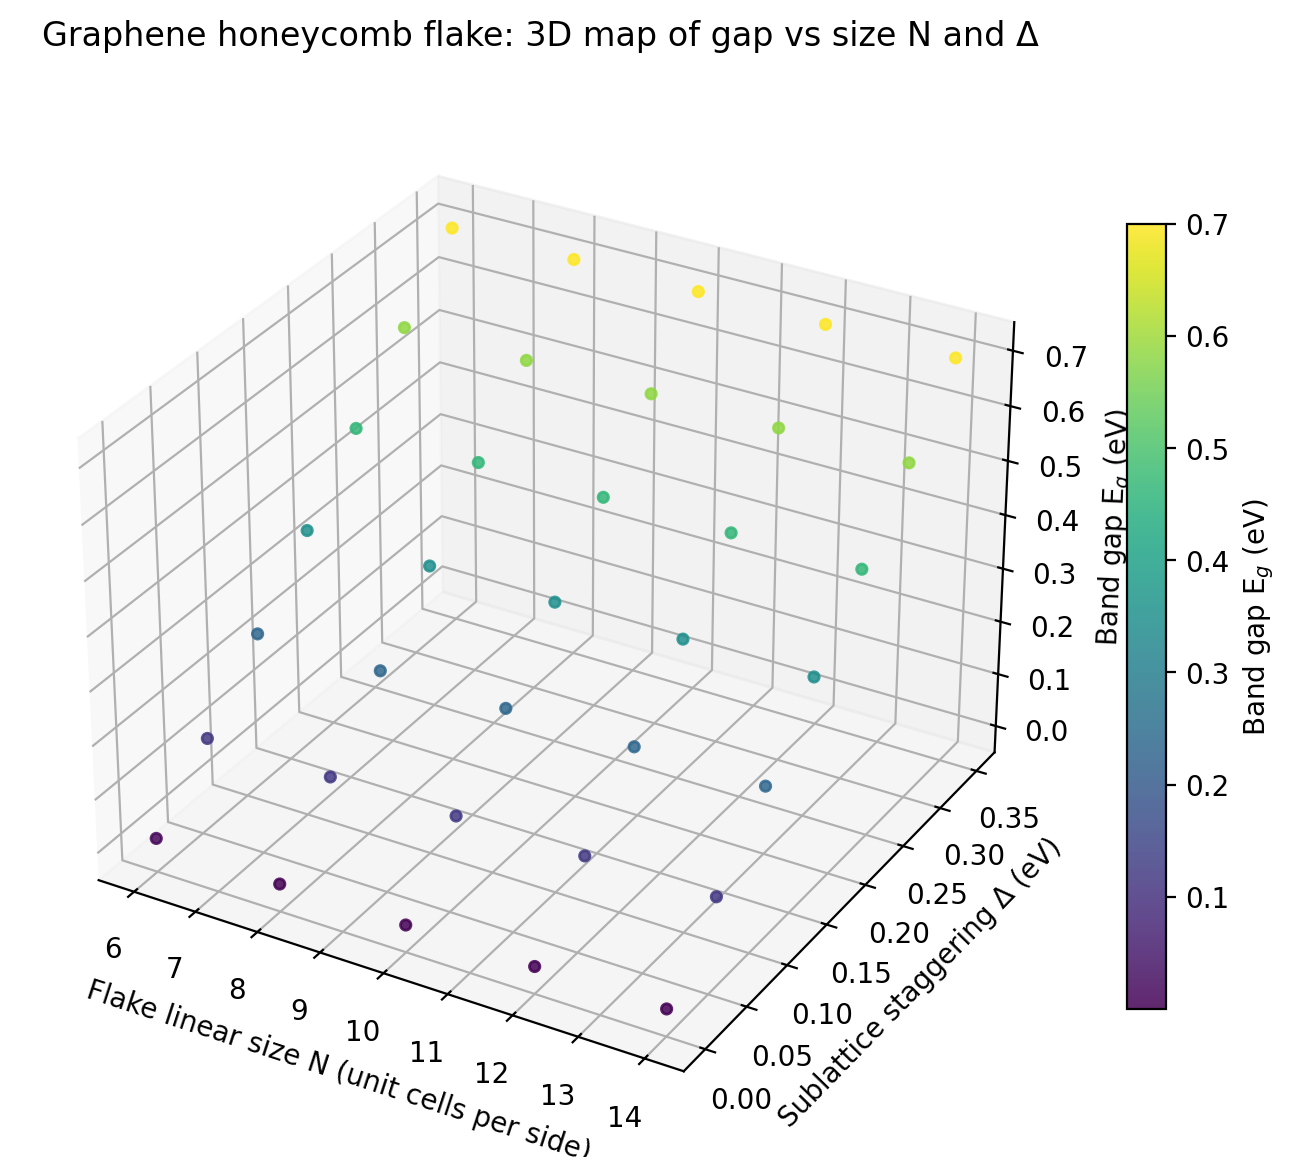

Saved figure: /content/data/Graphene_flake_gap_3D.png
Saved CSV: /content/data/Graphene_flake_gap_grid.csv


In [ ]:
# Re-run only the graphene flake scan with smaller grids for speed.
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

outdir = Path("/content/data")

# Use the same helper functions from the previous cell if available; otherwise redefine minimal ones.
try:
    graphene_flake_build
except NameError:
    t_graphene = -2.7
    def graphene_flake_build(Nx, Ny):
        import numpy as np
        n_sites = 2 * Nx * Ny
        H = np.zeros((n_sites, n_sites), dtype=float)
        def idx(i, j, s):
            return (i * Ny + j) * 2 + s
        for i in range(Nx):
            for j in range(Ny):
                ia = idx(i, j, 0)
                nbrs = []
                if 0 <= i < Nx and 0 <= j < Ny:
                    nbrs.append((i, j))
                if i-1 >= 0:
                    nbrs.append((i-1, j))
                if j-1 >= 0:
                    nbrs.append((i, j-1))
                for (u, v) in nbrs:
                    ib = idx(u, v, 1)
                    H[ia, ib] = H[ib, ia] = t_graphene
        return H
    def graphene_gap_for(N, Delta):
        import numpy as np
        Nx = Ny = N
        H = graphene_flake_build(Nx, Ny)
        for i in range(Nx):
            for j in range(Ny):
                ia = (i * Ny + j) * 2 + 0
                ib = (i * Ny + j) * 2 + 1
                H[ia, ia] += +Delta
                H[ib, ib] += -Delta
        E = np.linalg.eigvalsh(H)
        neg = E[E < 0.0]
        pos = E[E >= 0.0]
        if len(neg) == 0 or len(pos) == 0:
            return 0.0
        Eg = pos.min() - neg.max()
        return float(np.abs(Eg))

# Smaller grid
N_vals = list(range(6, 16, 2))   # 6,8,10,12,14
Delta_vals = np.linspace(0.0, 0.35, 7)

X, Y = np.meshgrid(N_vals, Delta_vals, indexing="xy")
Eg_grid = np.zeros_like(X, dtype=float)

for ii, N in enumerate(N_vals):
    for jj, D in enumerate(Delta_vals):
        Eg_grid[jj, ii] = graphene_gap_for(N, D)

xg = X.ravel().astype(float)
yg = Y.ravel().astype(float)
zg = Eg_grid.ravel()

# Plot
fig = plt.figure(figsize=(8.4, 6.8))
ax = fig.add_subplot(111, projection="3d")
sc = ax.scatter(xg, yg, zg, c=zg, s=14, alpha=0.85)
ax.set_xlabel("Flake linear size N (unit cells per side)")
ax.set_ylabel("Sublattice staggering Δ (eV)")
ax.set_zlabel("Band gap E$_g$ (eV)")
ax.set_title("Graphene honeycomb flake: 3D map of gap vs size N and Δ", pad=18)
fig.colorbar(sc, ax=ax, shrink=0.75, pad=0.05, label="Band gap E$_g$ (eV)")

graphene_img = outdir / "Graphene_flake_gap_3D.png"
fig.savefig(graphene_img, dpi=300, bbox_inches="tight")
plt.show()

import pandas as pd
pd.DataFrame({"N_size": xg, "Delta_eV": yg, "Eg_eV": zg}).to_csv(outdir/"Graphene_flake_gap_grid.csv", index=False)

print("Saved figure:", graphene_img)
print("Saved CSV:", outdir/"Graphene_flake_gap_grid.csv")


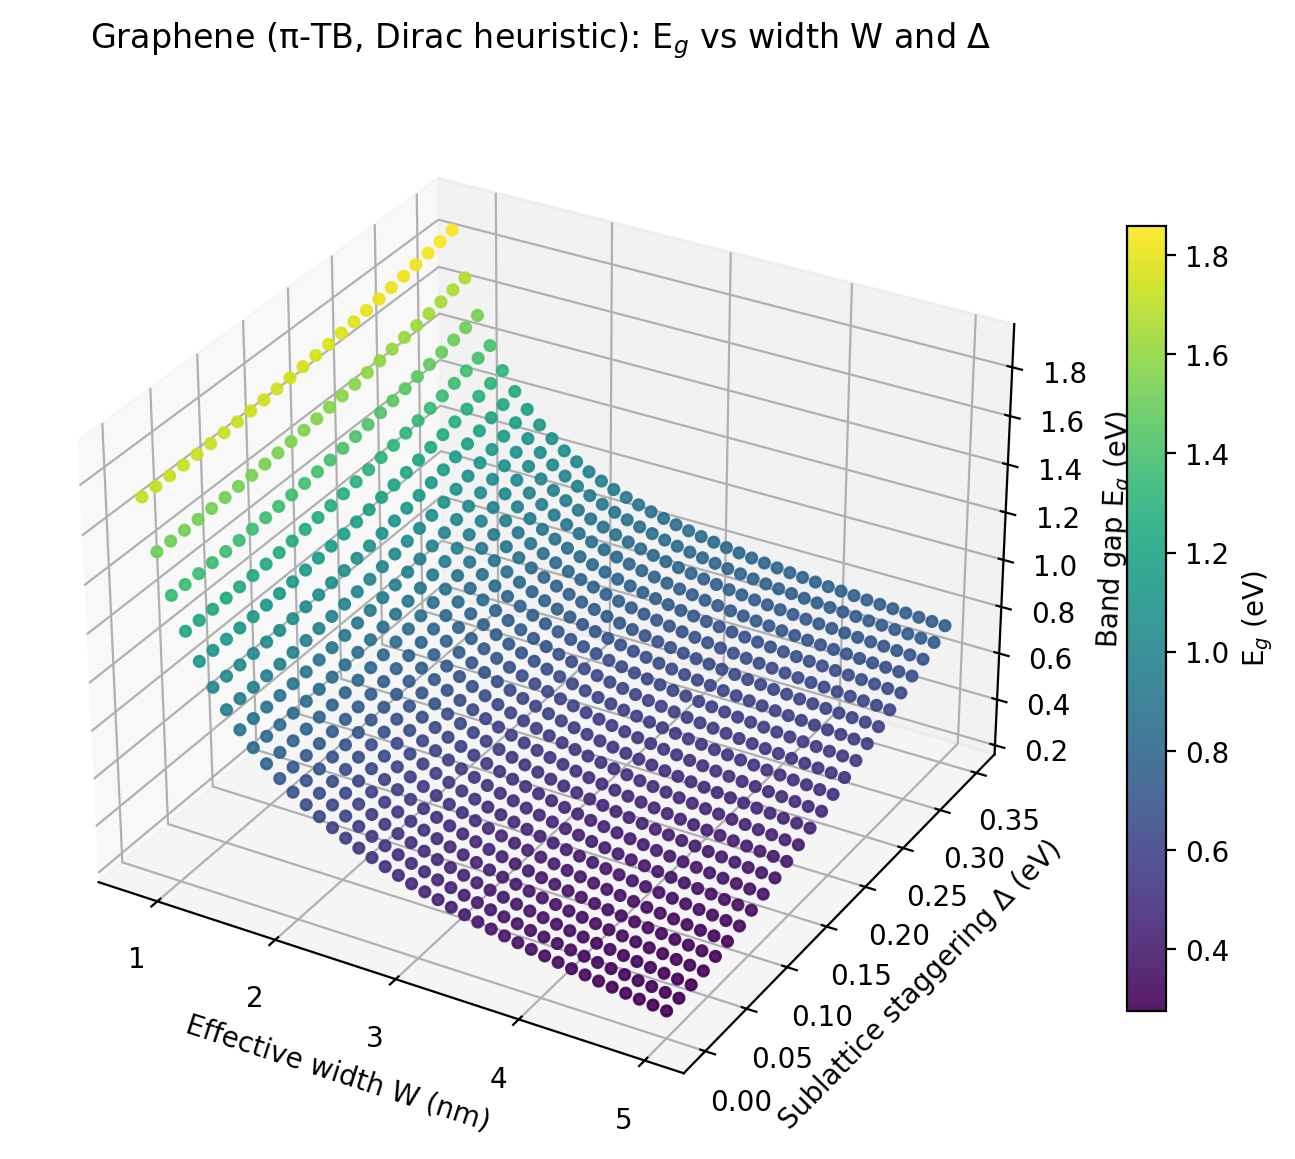

Saved figure: /content/data/Graphene_gap_heuristic_3D.png
Saved CSV: /content/data/Graphene_gap_heuristic_grid.csv


In [ ]:
# Lightweight graphene gap model (analytic, fast): Eg ≈ sqrt( (2Δ)^2 + (Eg_fs)^2 )
# where Eg_fs ≈ (2π/3) * (ħ v_F) / W for semiconducting armchair family (inverse with width W).
# This is a heuristic Dirac-based combination capturing: (i) sublattice mass gap Eg≈2Δ; (ii) finite-size quantization ~1/W.

import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

ħvF_eVnm = 0.658 # ~ħ v_F in eV·nm (v_F ≈ 1e6 m/s)

def Eg_graphene_approx(W_nm, Delta_eV):
    Eg_fs = (2.0*np.pi/3.0) * ħvF_eVnm / W_nm
    return np.sqrt((2.0*Delta_eV)**2 + Eg_fs**2)

# Grid
W_vals = np.linspace(0.8, 5.0, 40)        # ribbon/flake effective width in nm
Delta_vals = np.linspace(0.0, 0.35, 25)   # sublattice staggering (eV)

Wg, Dg = np.meshgrid(W_vals, Delta_vals, indexing="xy")
Eg = Eg_graphene_approx(Wg, Dg)

x = Wg.ravel()
y = Dg.ravel()
z = Eg.ravel()

# Plot
fig = plt.figure(figsize=(8.4, 6.8))
ax = fig.add_subplot(111, projection="3d")
sc = ax.scatter(x, y, z, c=z, s=14, alpha=0.9)
ax.set_xlabel("Effective width W (nm)")
ax.set_ylabel("Sublattice staggering Δ (eV)")
ax.set_zlabel("Band gap E$_g$ (eV)")
ax.set_title("Graphene (π-TB, Dirac heuristic): E$_g$ vs width W and Δ", pad=18)
fig.colorbar(sc, ax=ax, shrink=0.75, pad=0.05, label="E$_g$ (eV)")

outdir = Path("/content/data"); outdir.mkdir(parents=True, exist_ok=True)
img = outdir / "Graphene_gap_heuristic_3D.png"
fig.savefig(img, dpi=300, bbox_inches="tight")
plt.show()

import pandas as pd
pd.DataFrame({"W_nm": x, "Delta_eV": y, "Eg_eV": z}).to_csv(outdir/"Graphene_gap_heuristic_grid.csv", index=False)

print("Saved figure:", img)
print("Saved CSV:", outdir/"Graphene_gap_heuristic_grid.csv")